<a href="https://colab.research.google.com/github/chin0308/Research_Papers/blob/main/DE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy scipy matplotlib


Optimized Tilt Angle: 0.00°
Optimized Turbine Spacing: 50.00 m
Total Energy (Optimized): 84.09 kWh
Total Energy (Baseline): 82.31 kWh
Stability Penalty (Optimized): 16.17
Stability Penalty (Baseline): 15.69


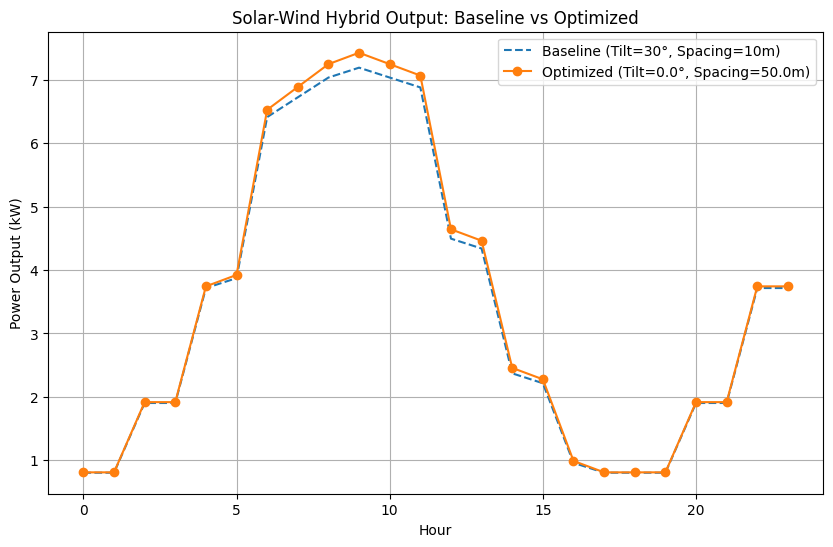

In [2]:
# Import necessary packages
import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

# Constants
SOLAR_EFFICIENCY = 0.18  # 18% efficiency for panels
WIND_POWER_RATED = 2.0   # 2 kW per turbine
HOURS = 24               # Simulate 24 hours

# Sample weather data (24-hour profiles)
solar_irradiance = np.array([
    0, 0, 0, 0, 0, 100, 300, 500, 700, 800,
    700, 600, 500, 400, 300, 200, 100, 0, 0, 0,
    0, 0, 0, 0
])  # in W/m²

wind_speed = np.array([
    3, 3, 4, 4, 5, 5, 6, 6, 7, 7,
    6, 6, 5, 5, 4, 4, 3, 3, 3, 3,
    4, 4, 5, 5
])  # in m/s

# Energy models
def solar_energy(tilt_angle, area=10):  # Tilt in degrees, area in m²
    tilt_rad = np.radians(tilt_angle)
    # Calculate effective irradiance assuming cosine effect (simplified)
    effective_irradiance = solar_irradiance * np.cos(tilt_rad)
    # Energy = area * efficiency * irradiance (converted to kWh)
    energy = area * SOLAR_EFFICIENCY * effective_irradiance / 1000
    # No negative energy values (e.g., nighttime)
    return np.clip(energy, 0, None)

def wind_energy(spacing, num_turbines=3):  # Spacing in meters
    # Simplified wake loss: More turbines with less spacing cause more losses
    wake_effect = 1 - 0.05 * (num_turbines - 1) / (spacing + 1)
    # Wind power: Cubic relationship with wind speed (normalized and capped)
    power_curve = np.minimum(wind_speed**3 / 100, WIND_POWER_RATED)
    energy = power_curve * wake_effect * num_turbines  # Energy per hour in kWh
    return energy

# Objective function for Differential Evolution
def objective(params):
    tilt_angle, spacing = params
    solar_output = solar_energy(tilt_angle)
    wind_output = wind_energy(spacing)
    total_energy = np.sum(solar_output) + np.sum(wind_output)

    # Grid stability: penalize rapid hourly changes
    combined_output = solar_output + wind_output
    stability_penalty = np.sum(np.abs(np.diff(combined_output)))

    # We want to maximize energy minus a stability penalty.
    # Differential evolution minimizes the objective, so we return its negative.
    return -(total_energy - 0.1 * stability_penalty)

# Optimization bounds: tilt between 0° and 90°, spacing between 5 and 50 meters.
bounds = [(0, 90), (5, 50)]

# Run Differential Evolution
result = differential_evolution(
    objective,
    bounds,
    strategy='best1bin',
    popsize=20,
    maxiter=50,
    seed=42
)

# Extract optimized parameters and convert objective value to positive energy
optimal_tilt, optimal_spacing = result.x
optimal_energy = -result.fun

# Calculate outputs with optimized parameters
solar_opt = solar_energy(optimal_tilt)
wind_opt = wind_energy(optimal_spacing)
combined_opt = solar_opt + wind_opt

# Baseline (unoptimized: tilt=30°, spacing=10m)
solar_base = solar_energy(30)
wind_base = wind_energy(10)
combined_base = solar_base + wind_base

# Print results
print(f"Optimized Tilt Angle: {optimal_tilt:.2f}°")
print(f"Optimized Turbine Spacing: {optimal_spacing:.2f} m")
print(f"Total Energy (Optimized): {np.sum(combined_opt):.2f} kWh")
print(f"Total Energy (Baseline): {np.sum(combined_base):.2f} kWh")
print(f"Stability Penalty (Optimized): {np.sum(np.abs(np.diff(combined_opt))):.2f}")
print(f"Stability Penalty (Baseline): {np.sum(np.abs(np.diff(combined_base))):.2f}")

# Plot results comparing baseline vs. optimized energy production profiles
plt.figure(figsize=(10, 6))
plt.plot(range(HOURS), combined_base, label='Baseline (Tilt=30°, Spacing=10m)', linestyle='--')
plt.plot(range(HOURS), combined_opt, label=f'Optimized (Tilt={optimal_tilt:.1f}°, Spacing={optimal_spacing:.1f}m)', marker='o')
plt.xlabel('Hour')
plt.ylabel('Power Output (kW)')
plt.title('Solar-Wind Hybrid Output: Baseline vs Optimized')
plt.legend()
plt.grid(True)
plt.show()
